Realizar estudios de aprendizaje supervisado utilizando árboles de decisión, tanto para clasificiación como para regresión. Para ello en esta tarea se usarán 4 datasets (los tres de la práctica anterior y uno que introduce series temporales).

**Ejercicio 2.** https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction. Clasificación binaria. El objetivo es clasificar entre presencia de enfermedad del corazón o no a partir de una serie de atributos (edad, sexo, colesterol, etc.). Para ello el dataset contiene una serie de datos pacientes etiquetados si tienen enfermedad o no.

**_Importación de librerías necesarias_**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from typing import Tuple
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO
import joblib

**_Preproceso_**

*Importación de los datos del datasets*

In [ ]:
drive.mount("/content/drive")

df_cardio = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/cardio.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Mostrar las primera y últimas filas del data frame importado*

In [ ]:
df_cardio
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no se jupiter se haría de la siguiente forma:
# df_cardio.head()
# df_cardio.tail()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Codifico las etiquetas ya que los modelos Naieve Bayes necesita que los datos estén en formato numérico. Además, nos va a hacer falta también falta para el mapa de calor y el describe.

In [ ]:
le = preprocessing.LabelEncoder()
df_cardio["Sex"] = le.fit_transform(df_cardio.Sex.values)
df_cardio["ChestPainType"] = le.fit_transform(df_cardio.ChestPainType.values)
df_cardio["RestingECG"] = le.fit_transform(df_cardio.RestingECG.values)
df_cardio["ExerciseAngina"] = le.fit_transform(df_cardio.ExerciseAngina.values)
df_cardio["ST_Slope"] = le.fit_transform(df_cardio.ST_Slope.values)

*Mostar parámetros estadísticos de los datos (media, desviación típica, quartiles, etc.).*

In [ ]:
df_cardio.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,0.781046,132.396514,198.799564,0.233115,0.989107,136.809368,0.404139,0.887364,1.361656,0.553377
std,9.432617,0.407701,0.956519,18.514154,109.384145,0.423046,0.631671,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,173.250000,0.000000,1.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,1.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


*Mostrar un mapa de calor que indique la correlación entre variables*

<Axes: >

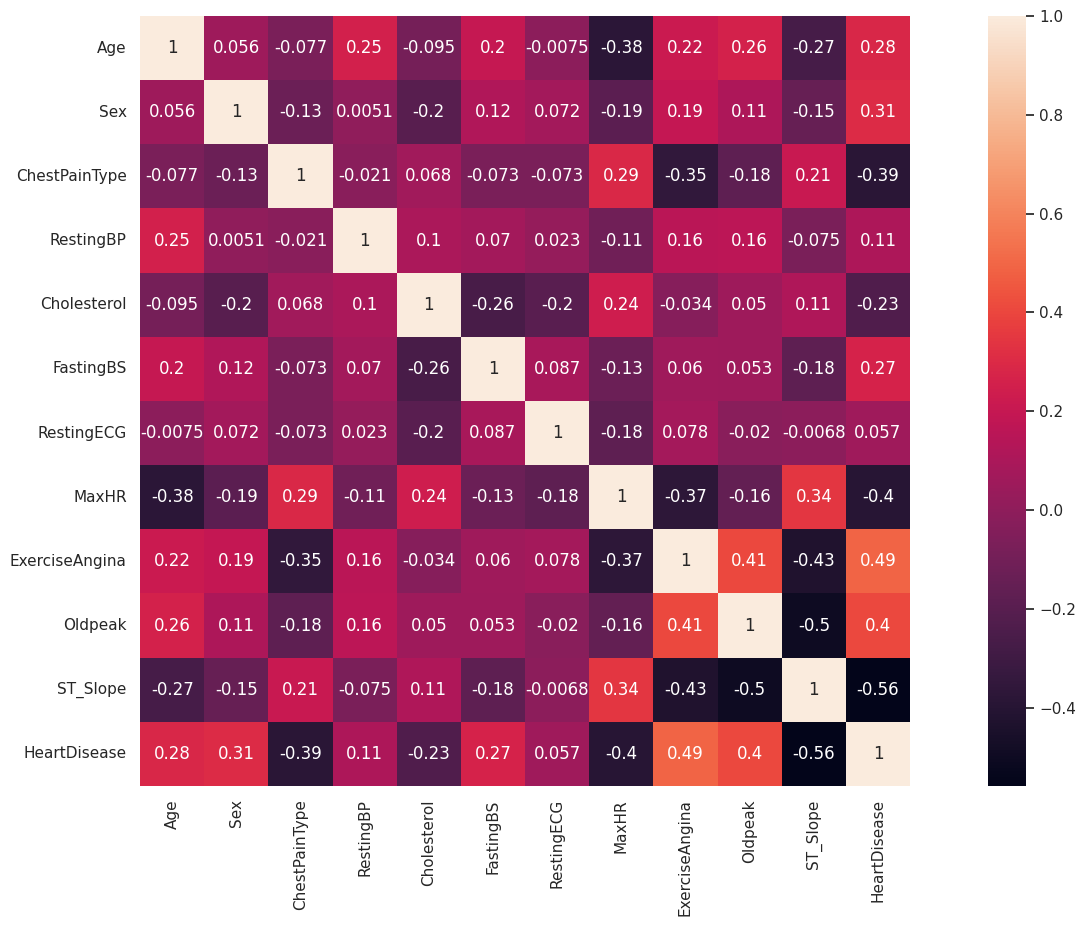

In [ ]:
sns.set(rc={"figure.figsize": (20, 10)}) # Esta es una forma de redimensionar el tamaño de la parcela
# plt.figure(figsize=(15, 8)) # Otra forma para redimensionar el tamaño de la parcela
sns.heatmap(df_cardio.corr(), square = True, annot = True)

*Seleccionar las características de entrada y etiquetas (resultados)*

In [ ]:
# Las características que se han elegido en un principio son las tienen un valor mayor a 0.2 o inferior a -0.2 en el mapa de calor.
scaler = preprocessing.MinMaxScaler()
# No se debe de hacer asi
x_df_cardio = scaler.fit_transform(df_cardio.drop(["RestingECG", "RestingBP", "HeartDisease"], axis=1))

y_df_cardio = df_cardio['HeartDisease']

*Separar datos entre entrenamiento y prueba (usando un 80% para entrenamiento y 20% test)*

In [ ]:
x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

**_Entrenamiento y predicción_**

_Elegir, instanciar (eligiendo unos valores concretos, por ejemplo profundidad del árbol 3) y entrenar el modelo_

In [ ]:
# Elijo este modelo porque es un problema de clasificación y no de regresión
modelo = DecisionTreeClassifier(criterion='gini', max_depth=3)
modelo.fit(x_entrenamiento, y_entrenamiento)

DecisionTreeClassifier(max_depth=3)

*Realizar una predicción con los datos de prueba*

In [ ]:
y_prediccion = modelo.predict(x_test)

_Mostrar el árbol de decisión resultante_

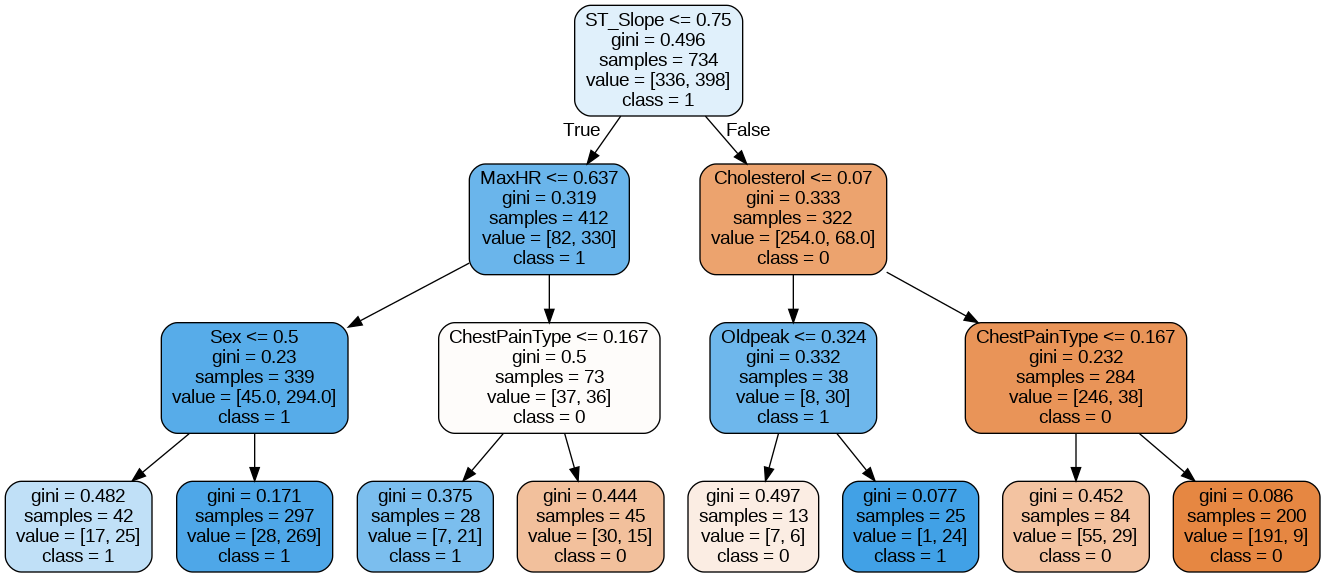

In [ ]:
dot_data = StringIO()

clases = [str(clase) for clase in modelo.classes_]

columnas = ['Age', 'Sex', 'ChestPainType', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

tree.export_graphviz(modelo, out_file=dot_data, class_names=clases, feature_names=columnas, rounded=True, filled=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())

Image(graph[0].create_png())

_Mostrar la importacia de cada atributo en el arbol resultante_

In [ ]:
caracteristicas = ['Age', 'Sex', 'ChestPainType', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
for caracteristica, importancia in zip(caracteristicas, modelo.feature_importances_):
  print(f"{caracteristica}: {importancia:.3f}")

Age: 0.000
Sex: 0.036
ChestPainType: 0.084
Cholesterol: 0.145
FastingBS: 0.000
MaxHR: 0.084
ExerciseAngina: 0.000
Oldpeak: 0.021
ST_Slope: 0.631


_Intenta guardar el modelo de predicción ya entrenado usando dump (https://scikit-learn.org/stable/modules/model_persistence.html)_

In [ ]:
# Guardo el modelo. Se guarda el fichero en colab en el directorio /content.
joblib.dump(modelo, "df_vino_modelo_entrenado.joblib")

['df_vino_modelo_entrenado.joblib']

**_Evaluación_**

*Mostrar el porcentaje de elementos correctamente clasificados*

In [ ]:
print("La probabilidad de acertar es: ", accuracy_score(y_test, y_prediccion))

La probabilidad de acertar es:  0.8641304347826086


*Mostrar la predicción realiza (imprimir la variable con la predicción)*

In [ ]:
print(y_prediccion)

[1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0
 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1
 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1]


*Representar gráficamente la clasificación obtenida (matríz de confusión).*

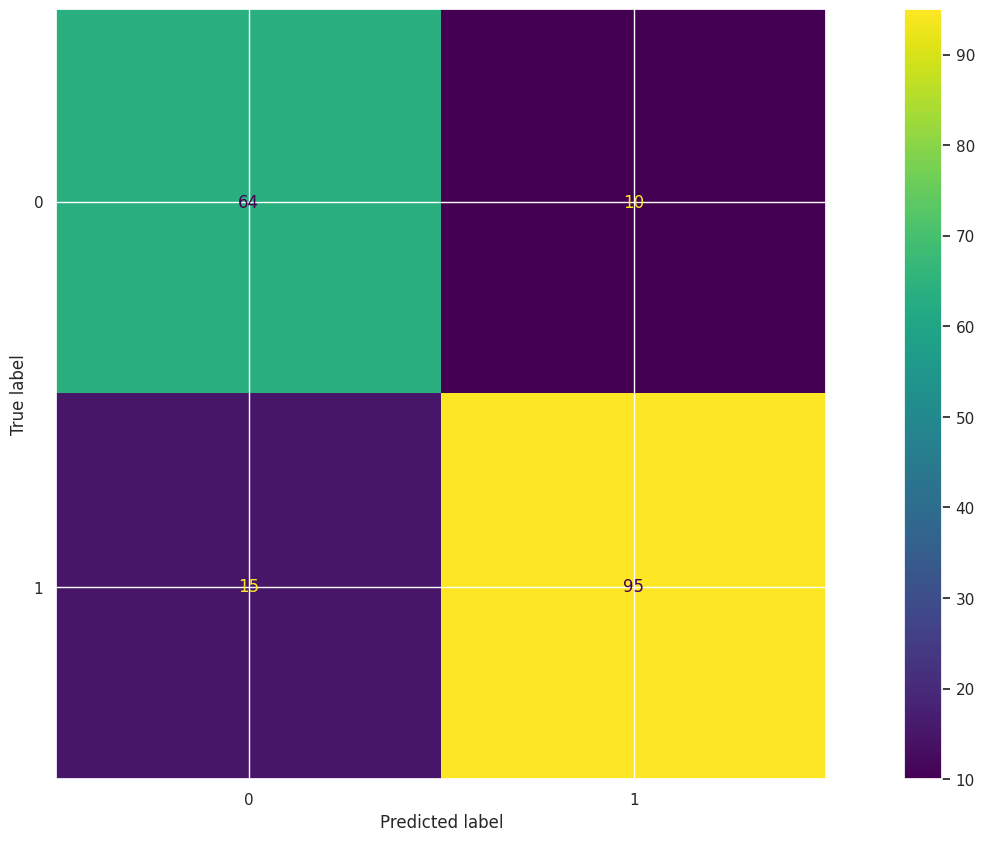

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prediccion)

**_Optimización de hiperparámetros_**

Elimino los atributos Age, FastingBS y ExerciseAngina porque al mostrar la importancia de cada atributo tienen un valor de 0.00.

_Calcula la combinación de parámetros óptima (profundidad de árbol y criterio). Para ello realiza ejecuciones con cada uno de los valores del criterio para los valores de profundidad de árbol de 1 a 15._

In [ ]:
# gini
scaler = preprocessing.MinMaxScaler()
# Elimino también
x_df_cardio = scaler.fit_transform(df_cardio.drop(["RestingECG", "RestingBP", "HeartDisease", "Age", "FastingBS", "ExerciseAngina"], axis=1))

y_df_cardio = df_cardio['HeartDisease']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(criterion='gini', max_depth=i)
  modelo.fit(x_entrenamiento, y_entrenamiento)

  y_prediccion = modelo.predict(x_test)

  df_opt.loc[len(df_opt)] = [i, accuracy_score(y_test, y_prediccion)]

print("Criterio elegido Gini: ")
df_opt

Criterio elegido Gini: 


,max_depth,prob_acertar
0,1.0,0.885870
1,2.0,0.831522
2,3.0,0.864130
3,4.0,0.847826
4,5.0,0.864130
5,6.0,0.826087
6,7.0,0.847826
7,8.0,0.842391
8,9.0,0.842391
9,10.0,0.820652


In [ ]:
# entropy
scaler = preprocessing.MinMaxScaler()
x_df_cardio = scaler.fit_transform(df_cardio.drop(["RestingECG", "RestingBP", "HeartDisease", "Age", "FastingBS", "ExerciseAngina"], axis=1))

y_df_cardio = df_cardio['HeartDisease']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(criterion='entropy', max_depth=i)
  modelo.fit(x_entrenamiento, y_entrenamiento)

  y_prediccion = modelo.predict(x_test)

  df_opt.loc[len(df_opt)] = [i, accuracy_score(y_test, y_prediccion)]

print("Criterio elegido entropy: ")
df_opt

Criterio elegido entropy: 


,max_depth,prob_acertar
0,1.0,0.885870
1,2.0,0.875000
2,3.0,0.864130
3,4.0,0.853261
4,5.0,0.853261
5,6.0,0.858696
6,7.0,0.820652
7,8.0,0.831522
8,9.0,0.820652
9,10.0,0.820652


_Cada ejecución anterior se deberá hacer usando validación cruzada (por ejemplo n_splits = 5). Con ello obtendremos una medida de bondad del modelo (accuaracy_score o mean_absolute_error), como lo ejecutaremos 5 vedes, calcularemos la media de esas 5 ejecuciones._

In [ ]:
# gini
scaler = preprocessing.MinMaxScaler()
x_df_cardio = scaler.fit_transform(df_cardio.drop(["RestingECG", "RestingBP", "HeartDisease", "Age", "FastingBS", "ExerciseAngina"], axis=1))

y_df_cardio = df_cardio['HeartDisease']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(max_depth=i)
  puntuaciones = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring='accuracy')


  df_opt.loc[len(df_opt)] = [i, np.mean(puntuaciones)]

print("Criterio elegido Gini: ")
df_opt

Criterio elegido Gini: 


,max_depth,prob_acertar
0,1.0,0.795704
1,2.0,0.812021
2,3.0,0.828422
3,4.0,0.837927
4,5.0,0.844749
5,6.0,0.829746
6,7.0,0.843388
7,8.0,0.836567
8,9.0,0.813447
9,10.0,0.824303


In [ ]:
# entropy
scaler = preprocessing.MinMaxScaler()
x_df_cardio = scaler.fit_transform(df_cardio.drop(["RestingECG", "RestingBP", "HeartDisease", "Age", "FastingBS", "ExerciseAngina"], axis=1))

y_df_cardio = df_cardio['HeartDisease']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "media_prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(max_depth=i)
  puntuaciones = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring='accuracy')


  df_opt.loc[len(df_opt)] = [i, np.mean(puntuaciones)]

print("Criterio elegido entropy: ")
df_opt

Criterio elegido entropy: 


,max_depth,media_prob_acertar
0,1.0,0.795704
1,2.0,0.812021
2,3.0,0.828422
3,4.0,0.839288
4,5.0,0.847470
5,6.0,0.829746
6,7.0,0.827034
7,8.0,0.833837
8,9.0,0.816140
9,10.0,0.824341


_Finalmente los parámetros elegidos serán los que den mejor media de esas medidas anteriormente nombradas._

Vemos que la probabilidad a partir de la profundidad máxima 3 empieza a decaer cuanto más profundidad se le da al modelo. Nos muestra que a partir de profundidad 3 puede ser que empiece un sobre ajuste que perjudica al modelo. Aunque no suele ser lo normal, el mejor criterio es el entropy y una profundidad máxima de 3.

_Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostramos los resultados._

In [ ]:
# entropy
scaler = preprocessing.MinMaxScaler()
x_df_cardio = scaler.fit_transform(df_cardio.drop(["RestingECG", "RestingBP", "HeartDisease", "Age", "FastingBS", "ExerciseAngina"], axis=1))

y_df_cardio = df_cardio['HeartDisease']

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

modelo = DecisionTreeClassifier(criterion='entropy', max_depth=3)
modelo.fit(x_entrenamiento, y_entrenamiento)

y_prediccion = modelo.predict(x_test)

print("La probabilidad de acertar es: ", accuracy_score(y_test, y_prediccion))


La probabilidad de acertar es:  0.8641304347826086
